In [1]:
import gym
import numpy as np
import pandas as pd
import multiprocessing as mp
from collections import deque
from time import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
%matplotlib inline

In [2]:
env = gym.make("LunarLander-v2")
env.reset()

array([ 0.00618305,  1.4184786 ,  0.6262614 ,  0.33592066, -0.00715782,
       -0.14185752,  0.        ,  0.        ], dtype=float32)

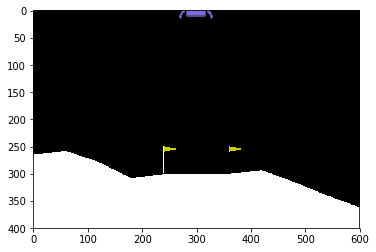

In [9]:
plt.imshow(env.render('rgb_array'))

In [4]:
n_actions = env.action_space.n

In [5]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    
    for i,r in enumerate(rewards_batch):
        if r > reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions

In [6]:
def generate_session(agent, t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [7]:
from IPython.display import clear_output


def show_progress(log,percentile=50,clear=False, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_rewards = log.mean(axis=1)
    thresholds = np.percentile(log, percentile, axis=1)

    if clear:
        clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_rewards[-1], threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(mean_rewards, label='Mean rewards')
    plt.plot(thresholds, label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(log[-1], range=reward_range)
    plt.vlines([thresholds[-1]],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [55]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=1 # make only 1 iteration on each .fit(...)
                      )
# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/kommiu/Projects/hse/RL/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [ ]:
def train(agent, pool, n_sessions=100, percentile=50,depth=1, n_iter=100, plot=False):
    
    states_batch = deque([], maxlen=depth*n_sessions)
    actions_batch = deque([], maxlen=depth*n_sessions)
    rewards_batch = deque([], maxlen=depth*n_sessions)
    
    times = []
    log = np.zeros((n_iter, n_sessions))
    
    for i in range(n_iter):
        t = []
        
        t.append(time())
        if pool:
            sessions = list(pool.imap_unordered(generate_session), [agent for _ in range(n_sessions)])
        else:
            sessions = [generate_session(agent) for _ in range(n_sessions)]
            
        t.append(time())
        s, a, r = map(np.array, zip(*sessions))
        
        t.append(time())
        
        states_batch.extend(s)
        actions_batch.extend(a)
        rewards_batch.extend(r)
        t.append(time())
        
        elite_states, elite_actions = select_elites(states_batch, actions_batch,rewards_batch, percentile)

        t.append(time())
        agent.fit(elite_states,elite_actions)
    
        t.append(time())
        log[i,:] = np.array(r)
        
        t.append(time())
        
        if plot:
            show_progress(log[:i+1], percentile, reward_range)
            t.append(time())
    
        times.append(t)


mean reward = -3.600, threshold=9.254


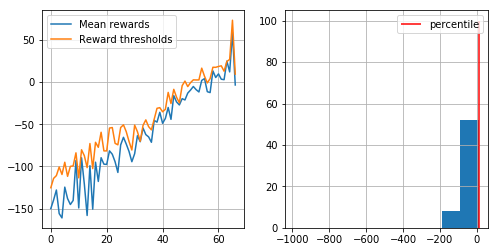

In [ ]:
n_sessions = 100
percentile = 60
log = []
depth = 1





for i in range(100):
    # generate new sessions
    pool = mp.Pool(processes=4)
    t = []
    t.append(time())
    
    sessions = [pool.apply(generate_session) for x in range(n_sessions)]
    
    t.append(time())
    s, a, r = map(np.array, zip(*sessions))
    
    t.append(time())
    states_batch.extend(s)
    actions_batch.extend(a)
    rewards_batch.extend(r)
    
    t.append(time())
    elite_states, elite_actions = select_elites(states_batch, actions_batch,rewards_batch,percentile)
    
    t.append(time())
    agent.fit(elite_states,elite_actions)
    
    t.append(time())
    show_progress(r, log)
    t.append(time())
    
    times.append(t)

    if np.mean(rewards_batch) >= 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [48]:
results[0][0][0]

array([ 0.0052    ,  1.4047449 ,  0.5266802 , -0.27447233, -0.00601863,
       -0.11930102,  0.        ,  0.        ], dtype=float32)

In [54]:
agent.predict_proba([env.reset()])[0]

array([0.34292109, 0.19614281, 0.32891377, 0.13202233])